In [1]:
import pandas as pd
import combined_score as cs
import scoring_dependencies as sd
import numpy as np


# Defining success

Samples (well per time point) were filtered for having sufficient cell density and number of events for analysis (500,000 cells/mL and 10,000 events respectively; see `preprocess_data.py`). Wells with insufficient cell density at any time point were excluded from analysis. Each of the remaining wells is assigned a numerical value that is the proportion of predicted ON events in the sample. Call this the prediction ratio.

Wells are defined as a success based on the following criteria.
* The prediction ratio for all three time points for a well exceeds a given threshold and the circuit has an intended ON state.
* The prediction ratio for all three time points for a well fall below a given threshold and the circuit has an intended OFF state. 
* Neither of the first two conditions hold, the prediction ratio is increasing over time, and the circuit has an intended ON state.
* Neither of the first two conditions hold, the prediction ratio is decreasing over time, and the circuit has an intended OFF state.

# Choose scoring thresholds

In [2]:
thresholds = [0.4,0.6]


In [3]:
names_key = {"UWBF_36564" : "DSGRN NOR low", "UWBF_36565" : "DSGRN NOR high", "UWBF_36566" : "DSGRN OR low", "UWBF_36567"  : "DSGRN OR high", "UWBF_36568" : "Simple NOR low", "UWBF_36569" : "Simple NOR high", "UWBF_36570"  : "Simple OR low", "UWBF_36571"  : "Simple OR high"}

# beta-estradiol first, doxycycline-hyclate second; e.g. 01 = BE gone and Dox present
transition_dict = {"r1fw4stb38ewsh" : "00->11", "r1fw4srz5dcaew" : "00->11", "r1fw4sqpyb7sww" : "00->11", "r1fqsg227dzvkj" : "00->01", "r1fqsfs6pm98h9" : "00->10", "r1fqsfkwxcccv6" : "00->10", "r1fqsftgsftdtw" : "01->11", "r1fqsfw543tey6" : "10->11", "r1fqsfn8au7bvp" : "01->11", "r1fqsfpj7u6prt" : "00->10", "r1fqsfqupgtnkv" : "01->11", "r1fqsfutgc5bab" : "00->01", "r1fqsfyqupyc24" : "10->11", "r1fqsg3bptd4mj" : "10->11","r1fqsfxekah8dh" : "00->01"}

media_dict = {"r1fw4stb38ewsh" : "Sorb", "r1fw4srz5dcaew" : "YEP", "r1fw4sqpyb7sww" : "SC", "r1fqsg227dzvkj" : "Sorb", "r1fqsfs6pm98h9" : "Sorb", "r1fqsfkwxcccv6" : "SC", "r1fqsftgsftdtw" : "Sorb", "r1fqsfw543tey6" : "SC", "r1fqsfn8au7bvp" : "SC", "r1fqsfpj7u6prt" : "YEP", "r1fqsfqupgtnkv" : "YEP","r1fqsfutgc5bab" : "SC", "r1fqsfyqupyc24" : "YEP", "r1fqsg3bptd4mj" : "Sorb","r1fqsfxekah8dh" : "YEP"}

confidence_dict = {"r1fw4srz5dcaew" : "high","r1fw4sqpyb7sww" : "high","r1fqsfs6pm98h9" : "high", "r1fqsfkwxcccv6" : "high", "r1fqsftgsftdtw" : "high", "r1fqsfn8au7bvp" : "high", "r1fqsfutgc5bab" : "high", "r1fqsfyqupyc24" : "high", "r1fqsfxekah8dh" : "high", "r1fw4stb38ewsh" : "low", "r1fqsg227dzvkj" : "low","r1fqsfw543tey6" : "low", "r1fqsfpj7u6prt" : "low", "r1fqsfqupgtnkv" : "low", "r1fqsg3bptd4mj" : "low"}

good_plates = ["r1fw4srz5dcaew","r1fw4sqpyb7sww","r1fqsfs6pm98h9", "r1fqsfkwxcccv6", "r1fqsftgsftdtw", "r1fqsfn8au7bvp", "r1fqsfutgc5bab", "r1fqsfyqupyc24", "r1fqsfxekah8dh"]

bad_plates = ["r1fw4stb38ewsh", "r1fqsg227dzvkj","r1fqsfw543tey6", "r1fqsfpj7u6prt", "r1fqsfqupgtnkv", "r1fqsg3bptd4mj"]

# Cleaned Model

Size of files: (369,2769,3138)
Size concat: 3059, Size grouped: 1084
Number missing is 129
Number present is 955
Filtered samples per plate (max 10*15 or 10*14 for dropped wsh), then avg prop successes of 10.
DSGRN NOR low
sum of samples: 120, avg success: 0.50
DSGRN NOR high
sum of samples: 128, avg success: 0.42
DSGRN OR low
sum of samples: 125, avg success: 0.61
DSGRN OR high
sum of samples: 128, avg success: 0.31
Simple NOR low
sum of samples: 120, avg success: 0.24
Simple NOR high
sum of samples: 114, avg success: 0.15
Simple OR low
sum of samples: 121, avg success: 0.44
Simple OR high
sum of samples: 99, avg success: 0.53
8
112


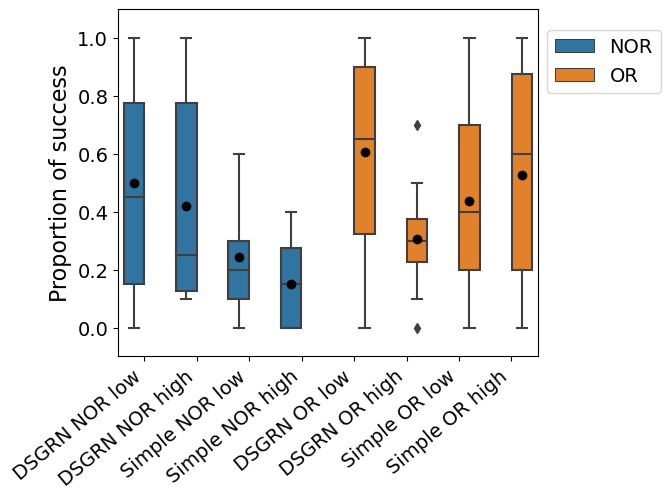

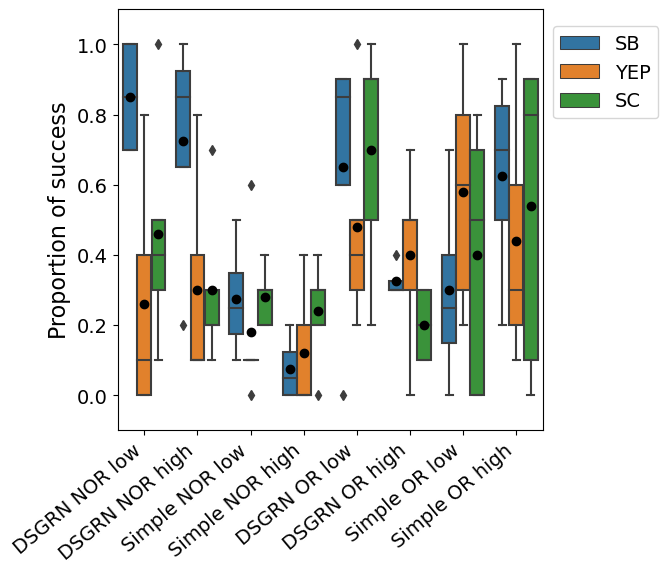

In [4]:
# # Concatenate Titration and Fixed Ratio, Cleaned Model
meta_fr = "processed_metadata_for_time_trending_2021_12_13/FixedRatio_HL2_cleanModel_meta_concat_split_inducers_drop_UWBF_6390_timetrend_drop_plate_wsh.csv"
# meta_fr = "processed_metadata_for_time_trending_2021_12_13/FixedRatio_HL2_cleanModel_meta_concat_split_inducers_drop_UWBF_6390_timetrend.csv"
meta_ti = "processed_metadata_for_time_trending_2021_12_13/Titration_HL1_cleanModel_meta_concat_split_inducers_drop_UWBF_6390_timetrend.csv"
fr_df = pd.read_csv(meta_fr)
ti_df = pd.read_csv(meta_ti)
meta_df = pd.concat([fr_df,ti_df],ignore_index=True,sort=False)
print("Size of files: ({},{},{})".format(len(fr_df),len(ti_df),len(meta_df)))

savename = "cleanModel_combined_score_drop_wsh.csv"

grouped_df,exp_ids = sd.analyze(meta_df)
df,final_dict = cs.get_scores(grouped_df,savename,names_key,thresholds)
# print(sorted(set([x[5:7] for x in df["group"].unique()])))
results_df,stats_clean,predictions_clean = cs.aggregate_scores(df,names_key,exp_ids,savename,thresholds)

cs.plot_by_plate_category(results_df,good_plates+bad_plates,savename.split(".")[0]+".pdf",['success'])
cs.plot_by_plate_category_media(results_df,good_plates+bad_plates,savename.split(".")[0]+"_media.pdf",['success'])

# Summary over predictions, cleaned model

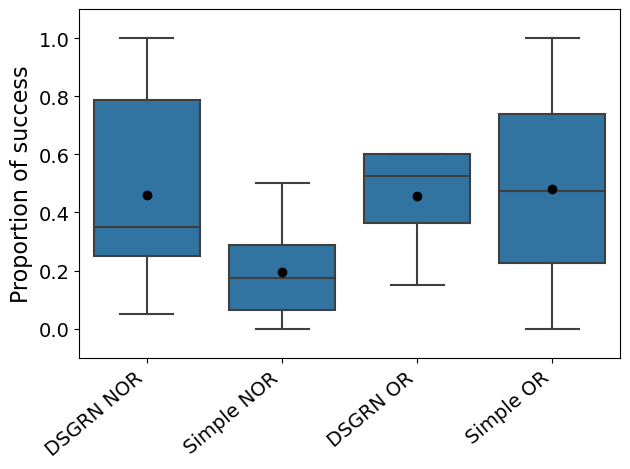

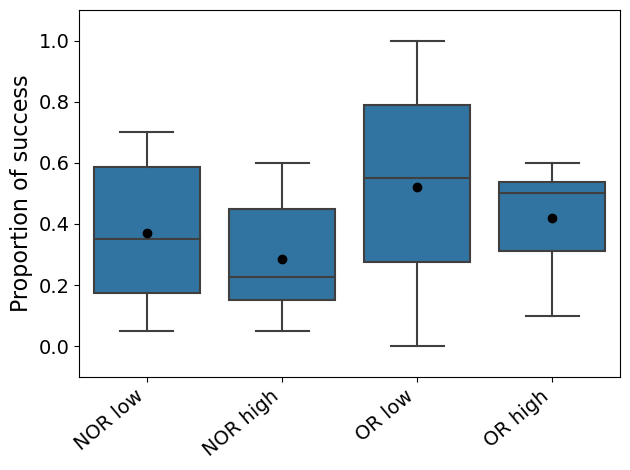

In [5]:
# Different groupings
cs.plot_by_plate_category_predictions(predictions_clean,good_plates+bad_plates,savename.split(".")[0],ylim=[-0.1,1.1])